In [43]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from dipy.reconst.dti import TensorModel
from dipy.core.gradients import gradient_table

import scipy.sparse as sp

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das
import D2_direct_solver as dds

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)
importlib.reload(dds)

<module 'D2_direct_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_direct_solver.py'>

# Preprocess the data

In [2]:
# run the Converting.ipynb first
data = np.load('/Users/xunan/Projects/MaxEnt/Data/Processed_Ning.npz')
Sb0 =   data['Sb0']
Sqs =   data['Sqs']
qs =    data['qs']
sigma_TE = data['sigma_TE']
sigma_va = data['sigma_va']

In [ ]:
# Identify the whole brain region
mask = bf.mask_brain(Sb0, median_radius = 1, numpass = 4, vol_idx = [0, 1, 2, 3, 4], least_size = 100, keep_top = 3)


+-----------------------------------------------------------------------------+
Number of initial valid regions: 3
Sizes of each regions (1st is background): [399913  97229    321    201]
+-----------------------------------------------------------------------------+
Number of kept regions: 3
Sizes of kept regions: [97229   321   201]


In [ ]:
# Load TE71ms DWI + gradients
wm_data = nib.load("/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/TE71ms/Processed/dwi_eddy_unring.nii").get_fdata()
bvals = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/TE71ms/Processed/dwi_bval.txt")
bvecs = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/TE71ms/Processed/dwi_ed_bvec.txt")

gtab = gradient_table(bvals=bvals, bvecs=bvecs)
tenmodel = TensorModel(gtab)
tenfit = tenmodel.fit(wm_data)

FA = tenfit.fa


In [ ]:
wm_mask = (FA > 0.25)               # This is the white matter mask
mask = mask & wm_mask               # intersect the whole brain mask with the white matter mask to get the final mask

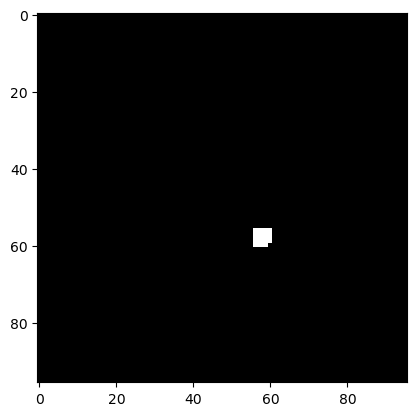

In [50]:
plt.imshow(np.fliplr(np.flipud(mask[:, :, 27].T)), cmap='gray')
plt.show()

# On personal computer, select a small area to run the algorithm

In [48]:
select_mask = np.zeros_like(mask, dtype=bool)       # all False
select_mask[35:40, 35:40, 25:30] = True             # set region to True
mask = mask & select_mask

lin2idx = bf.mask_to_lin2idx(mask)
print("V = ", np.sum(mask))

V =  113


In [26]:
theta1 = np.linspace(0, 3, 100)
theta2 = np.linspace(0, 30, 100)
thetas, weights = bf.Cartesian(theta1, theta2)
R = rr.R_mask(mask, 25, order = 2)
# R = rr.R_all((3, 3, 3), 25, order = 2)
# R = sp.csr_matrix(np.zeros((25, 25)))

In [62]:
lambdas, f_hat, history = das.admm( qs, thetas, weights, Sqs[mask, :], sigma = sigma_va[mask, :].ravel(),
                                    R_csr = R, f0 = None, normalize = True, Lambdas = None, 
                                    beta = 0.5, c = 1e-4, epsilon = 1e-10, tol = 1e-10, maxiter = 1,
                                    cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000,
                                    rho = 0.1, rho_ratio = 2, dynamic_rho = True,
                                    admm_tol = 1e-10, admm_maxiter = 100)


ADMM maximum iterations reached.


# Read the results

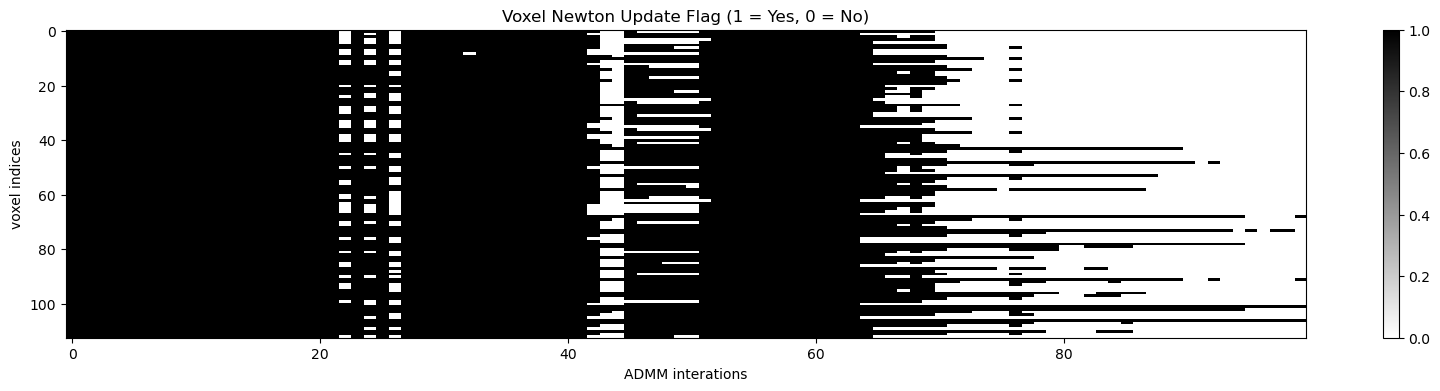

In [63]:
plt.figure(figsize=(20, 4))
plt.imshow(history[4], cmap='gray_r', aspect='auto', interpolation='none')
plt.title('Voxel Newton Update Flag (1 = Yes, 0 = No)')
plt.xlabel('ADMM interations')
plt.ylabel('voxel indices')
plt.colorbar()
plt.show()


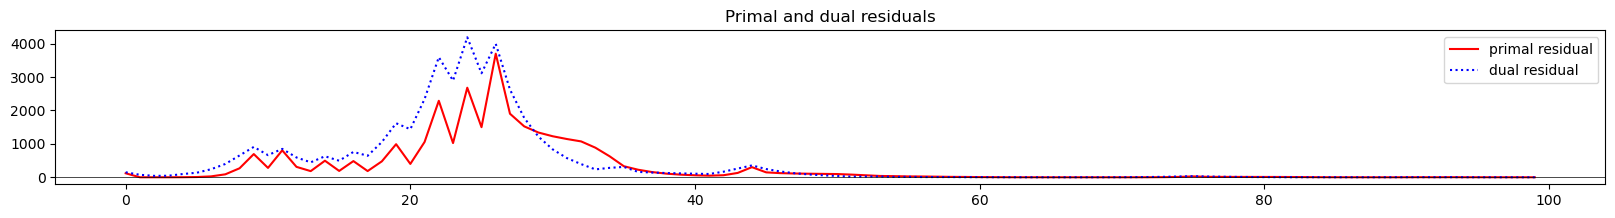

In [64]:
plt.figure(figsize=(20,2))
plt.plot(history[1][:], '-', color = 'red', label = 'primal residual')
plt.plot(history[2][:], ':', color = 'blue', label = 'dual residual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Primal and dual residuals')
plt.legend()
plt.show()


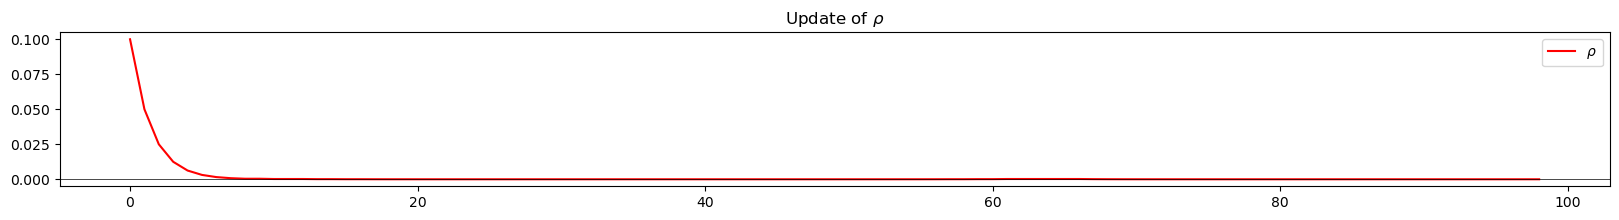

In [65]:
plt.figure(figsize=(20,2))
plt.plot(history[3][:], '-', color = 'red', label = r'$\rho$')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title(r'Update of $\rho$')
plt.legend()
plt.show()

In [66]:
# The voxels still doing Newton updating at the lase ADMM interation
np.where(history[4][:, -1] >= 1)

(array([ 68,  91, 101, 106]),)

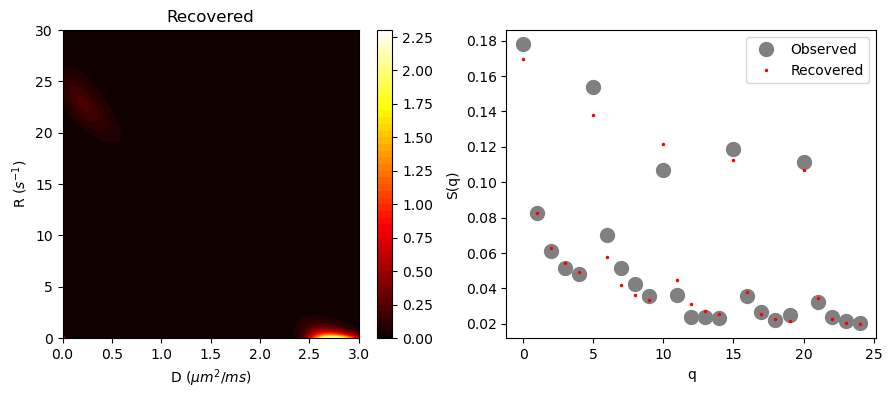

In [67]:
bf.contourf_compare(theta1, theta2, f_hat[68].ravel(), qs, Sqs[mask, :][68].ravel())

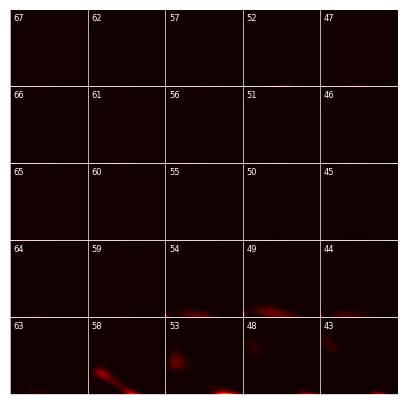

In [82]:
# axis corresponds to the three axis of the brain
# slice is the index under global coordinate
bf.contourf_mask(theta1, theta2, f_hat, lin2idx, axis = 0, slice = 37)

In [71]:
# This is used to identify the crashed voxels
# Sometimes, the voxel still doing Newton update is a potential crashed voxel
crashed_lin = np.where(history[4][:, -1] >= 1)
crashed_idx = np.where(np.isin(lin2idx, crashed_lin))
print(crashed_lin)
print(crashed_idx)
print(len(crashed_lin[0]))

(array([ 68,  91, 101, 106]),)
(array([38, 39, 39, 39]), array([35, 35, 37, 38]), array([25, 25, 25, 26]))
4


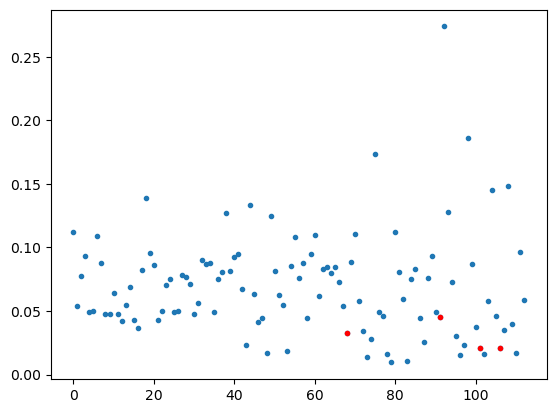

In [ ]:
diff = np.linalg.norm(Sqs[mask, :] - bf.get_Sqs(bf.kernel(qs, thetas), weights, f_hat), axis = 1)
plt.plot(diff, '.')
plt.xlabel('voxel indices')
plt.ylabel(r'$\|S - \hat{S}\|_2^2$')
plt.plot(crashed_lin[0], diff[crashed_lin], '.', color = 'red')

In [80]:
np.linalg.norm(Sqs[mask, :] - bf.get_Sqs(bf.kernel(qs, thetas), weights, f_hat))

np.float64(0.8504880619511769)